<a href="https://colab.research.google.com/github/vpreston/rjmcmc/blob/master/RJMCMC_Tutorial_and_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Quick Guide on RJMCMC 

This notebook will walk through some of the fundamentals of RJMCMC and ultimately present and comment on the coal mining example from Greene's paper. 


Please note, that everything in this notebook will natively run within Colaboratory and should be browser/machine agnostic.

In [0]:
#Begin by importing necessary libraries for this tutorial
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import pandas as pd
from scipy.special import gamma
from scipy.stats import stats

## Motivation

Let's begin by gaining some intuition about one type of candidate problem for RJMCMC: multiple change-point problems. Consider a simple one-dimensional dataset like that in the coal mining problem: merely a series of dates of coal mining diasters (cheery). We're interested in characterizing the rate at which disasters occured, but when we plot the data, we notice that the rate of occurances doesn't quite seem to be the same for all time:

In [0]:
coal_df = pd.read_table('coal.csv', delimiter=',') #read the csv file of raw data in as a pandas dataframe
print(coal_df.head(5)) #print the first 5 lines of the dataframe

          date
1  1851.202601
2  1851.632444
3  1851.969199
4  1851.974675
5  1852.314168


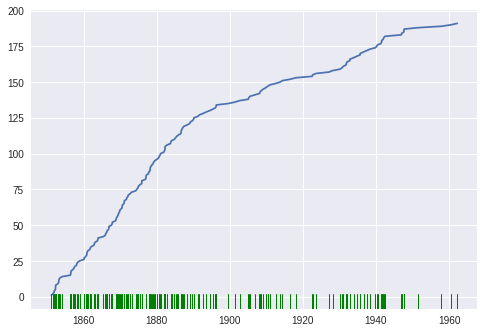

In [0]:
plt.plot(coal_df.date.values, coal_df.index)
sns.rugplot(coal_df.date, color='g')

For more insight, we can take a look at the histogram of the data:

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


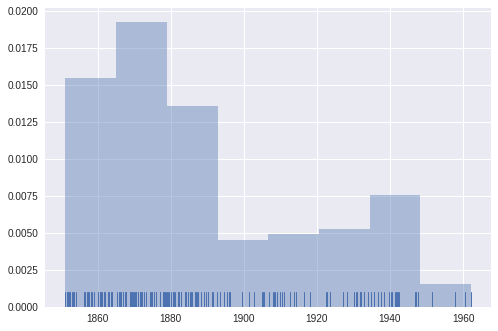

In [0]:
sns.distplot(coal_df.date.values, kde=False, rug=True, norm_hist=True);

Indeed, we can clearly see that there is some "structure" to the data -- prior to 1890 there appears to be many more coal mining disasters than after, and there also appears to be a further nontrivial jump after 1950. 

Ultimately, it is the supposed structure of this data that encourages us to consider using a step function to characterize the distribution. In context, this could be akin to saying "prior to 1950 we used canaries to detect dangerous gas levels, but in 1950 we immediately introduced automatic gas detection to all mines monitored in the study" and we're looking at a major change in a parameter of mine safety being switched (like in a step function).

Now, the questions are: **how many steps were there? when did they occur? what characteristics (height) does each step have?**

Prior to introducing RJMCMC, one way of answering this question could have involved fixing the number of steps (in studies presented in Greene, this occasioanlly meant using only 2 steps), and performing sampling/inference to address the other questions. RJMCMC however is a method which allows us to also perform inference over how many discrete steps there are, and conditioned on that, characterize when they may have occured and what height they have.

Let's now take a closer look at RJMCMC for the coal mining problem. We would like to estimate $k$, the number of change points there are, *heights* the height of the step function (this is the same as the rate of disasters), and *change points* the place at which we're stepping. 

In general, RJMCMC takes the following algorithmic form:

1.   Randomly choose a *move* to make in the candidate model space
2.   Propose an update to the model with respect to the chosen move
3.   Determine, based on our data, whether to *accept* the proposal
4.   *Update* the candidate model according to whether the proposal was accepted

For the step function problem, like that in the coal mining example, the authors propose 4 types of moves:

1.   *pose_move*: Move the position of a change point. As a matter of notation, positions (changepoints) will be written as $s$.
2.   *height_move*: Move a step's height. As a matter of notation, heights will be written as $h$.
3.   *birth_move*: Increase the number of steps by 1, and update change points and heights accordingly
4.   *death_move*: Decrease the number of steps by 1, and update change points and heights accordingly




## Toy Scenario for Intuition Building

For the purposes of this tutorial, we're going to walk through RJMCMC on a dataset where we have the "ground truth" of the step function to illustrate how each move works and assess the method. Then, we're going to walk through the coal mining example.

The example data is gnerated below. **Please note:** this dataset will be different each time you run the notebook.


Changepoints
[0.0, 24.525431738780746, 64.74645810183523, 100.0]
Rates of Change
[2.79005406 1.51629184 4.02456235]


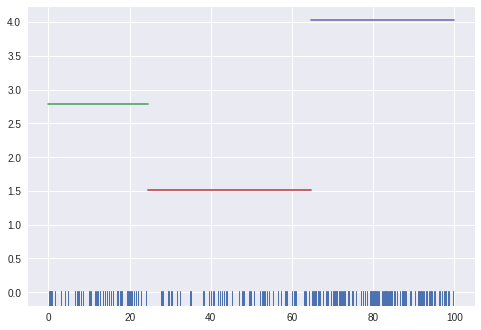

In [0]:
exa = 1
exb = 0.5

exh = np.random.gamma(shape=exa, scale=1/exb, size=3) #let there be 3 steps (rates)
tempc = np.random.uniform(0,100,2) #two internal changepoints
exc = [0., tempc[0], tempc[1], 100.]
exc.sort()

#draw samples from the different regions
data = []
for i in range(0, len(exh)):
  data = data + list(np.random.uniform(exc[i], exc[i+1], int((exc[i+1]-exc[i])*exh[i])))

#visualize the data
print('Changepoints')
print(exc)
print('Rates of Change')
print(exh)
sns.distplot(data, rug=True, kde=False, hist=False)
for i in range(0, len(exh)):
  plt.plot([exc[i], exc[i+1]], [exh[i], exh[i]])


Keep the changepoints and heights in mind, because we'll be comparing against these in the coming cells. Let's start building our sampler by getting a grip on each of the moves.

# The Moves

The *height_move* encodes the idea of changing the height of one of the steps. The authors assume that heights are draw from a gamma distribution parameterized by $\alpha$ and $\beta$ such that the density is:

$$\frac{\beta^\alpha h^{\alpha - 1}e^{-\beta h}}{\Gamma (a)}$$

Making a height move does not change the dimensionality of the problem, but does change one of the parameters of interest. To propose a new height, we randomly select an $h_j$ and create an $h_{jp}$ such that the $log\frac{h_{jp}}{h_j}$ is uniformly distributed from -0.5 to 0.5. As the authors state, this is primarily for *convenience* to make the proposal density have a simple form. 

The acceptance probability for this move is:

$$min(1, L(\frac{h_{jp}}{h_j})^{\alpha} exp(-\beta (h_{jp} - h_{j})))$$

where $L$ is the likelihood ratio $\frac{p(y|x_p)}{p(y | x)}$ where $x$ is the parameter proposal and $y$ is the data.

The log-likelihood is given by:

$$\sum_{i = 1}^n log(x(y_i)) - \int_0^L x(t) dt$$

where $x(t)$ is the rate function (which we assume to be a step function). Practically speaking, we can interpret the log-likelihood ratio then as:

$$\sum_{i = 1}^n log(x_p(y_i)) - \int_0^L x_p(t) dt - \sum_{i = 1}^n log(x(y_i)) + \int_0^L x(t) dt$$

where, grouping terms, we can say that the second term reduces to:

$$-\int_0^L x_p(t) dt + \int_0^L x(t) dt = -h_{jp}(s_{j-1} - s_{j}) + h_j(s_{j-1} - s_{j}) = (h_{j} - h_{jp})(s_{j-1} - s_{j})$$

which we can see by applying the Lebesque integral and we primarily look at the section of the entire function that changes with respect to this move.

The first terms reduces to:

$$\sum_{i = 1}^n log(x_p(y_i)) - \sum_{i = 1}^n log(x(y_i)) = \sum_{i = 1}^n (log(x_p(y_i)) - log(x(y_i))) = \mu(log(h_{jp}) -log(h_j)) $$

where $\mu$ is the number of observations that fall between $s_{j}$ and $s_{j+1}$ which is the only place the difference between the two quantities will be greater than 0.

In code, we can now write the *height_move* function:








In [0]:
def height_move(changepts, heights, k, alpha, beta, obs_func):
    '''Move for the height of a step
    INPUTS:
     - changepts (list of floats)
     - heights (list of floats)
     - alpha (int)
     - beta (int)
     - obs_func (func handle): helper function for counting data in an interval
    RETURNS: heights'''
    
    #randomly choose an index in heights
    j = np.random.randint(0, max(k-1, 1))
    
    #propose a change (hprime) so that the log ratio of the proposal and
    #current value is uniformly distributed between [-0.5, 0.5]
    u = np.random.uniform(-0.5, 0.5)
    h_prime = heights[j] * np.exp(u)
    
    #calculate acceptance probability
    mu = obs_func(changepts[j], changepts[j+1]) #data count in interval
    log_likelihood = (heights[j] - h_prime)*(changepts[j+1] - changepts[j]) + \
                      mu*(np.log(h_prime) - np.log(heights[j]))
    height_ratio = np.power(h_prime/heights[j], alpha) * np.exp(-beta*(h_prime-heights[j]))
    prob = min(1, np.exp(log_likelihood) * height_ratio)
    
    #return updated heights
    if np.random.uniform() < prob:
      new_heights = list(tuple(heights))
      new_heights[j] = h_prime
      heights = list(tuple(new_heights))
    return heights

Let's see how this performs on our example dataset. Remember, we have some insight about the generative model (and thus know alpha and beta). We can only adjust the rates we infer, so the changepts here will be fixed.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Count')

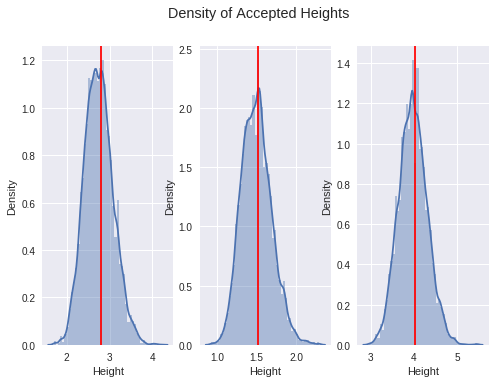

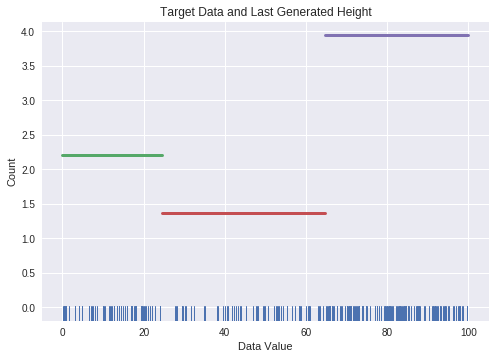

In [0]:
heights = [1., 1., 1.] #guess of rates
changepts = [0., exc[1], exc[2], 100.] #giving the best changepts (the real ones)
# changepts = [0, 30, 70, 100] #try other changepts to see behavior
k = 4
alpha = exa
beta = exb
example_data = data
obs_func = lambda x, y: sum(1 for i in example_data if x <= i <= y)

#perform several iterations of the height move and record results
new_heights = []
for i in range(0,44000):
  heights = height_move(changepts, heights, k, alpha, beta, obs_func)
  if i >= 4000: #allow for a little burn-in
    new_heights.append(tuple(heights))

#plot results
fig, ax = plt.subplots(1, 3)
for i in range(0, len(heights)):
  temp = [m[i] for m in new_heights]
  sns.distplot(temp, kde=True, rug=False, ax=ax[i])
  ax[i].axvline(x=exh[i], color='r')
  ax[i].set_xlabel('Height')
  ax[i].set_ylabel('Density')
fig.suptitle('Density of Accepted Heights')

plt.figure()
sns.distplot(example_data, kde=False, rug=True, hist=False)
for i in range(0, len(heights)):
  plt.plot([changepts[i], changepts[i+1]],[heights[i],heights[i]], lw=3)
plt.title('Target Data and Last Generated Height')
plt.xlabel('Data Value')
plt.ylabel('Count')

As we can see, when we give the sampler the best chance possible (the true change points), it indeed does pretty well. Feel free to play with the changepts and see how performance varies. Does what you see make sense? What if we don't know the change points?

The *pose_move* is similar in form to the *height_move*, in that this should be a relatively straightforward update of the value of an existing parameter (and no dimensions will be changed). In this case, we assume that poses are drawn uniformly across the entire valid interval, so our acceptance probability can be written:

$$min(1, L\frac{(s_{j+1} - s_{jp})(s_{jp} - s_{j-1})}{(s_{j+1}-s_{j})(s_j - s_{j-1})})$$

where the log-likelihood ratio ($log(L)$) in this case can be expressed as:

$$\sum_{i = 1}^n log(x_p(y_i)) - \int_0^L x_p(t) dt - \sum_{i = 1}^n log(x(y_i)) + \int_0^L x(t) dt$$

where:

$$-\int_0^L x_p(t) dt + \int_0^L x(t) dt = -h_{j-1}(s_{jp} - s_{j-1}) - h_j(s_{j+1} -  s_{jp}) + h_{j-1}(s_{j} - s_{j-1}) + h_j(s_{j+1} -  s_{j}) = (h_{j} - h_{j-1})(s_{jp} - s_{j})$$

and:

$$\sum_{i = 1}^n log(x_p(y_i)) - \sum_{i = 1}^n log(x(y_i)) = \mu_{bp}log(h_{j-1}) - \mu_blog(h_{j-1}) + \mu_{ap}log(h_j) - \mu_alog(h_j)$$

where $\mu_bp$ is the number of observations that fall within the new interval $s_{j-1}$ to $s_{jp}$, $\mu_b$ is the number of observations that fell within the old interval $s_{j-1}$ to $s_{j}$, and $\mu_{ap}$ and $\mu{a}$ are the complements of these (everything falling from the changed lower bound to $s_{j+1}$). 

We can now write out this move functionally:


In [0]:
def pose_move(changepts, heights, k, obs_func):
    '''Move the position of a changepoint
    INPUT
     - changepts (list of floats)
     - heights (list of floats)
     - k (int)
     - obs_func (function handle)
    RETURNS: changepts'''
    
    #randomly choose an index in positions
    j = np.random.randint(0, max(k-1, 1))
    
    #propose a change (sprime) uniformly distributed between the previous pose and the next pose
    s_prime = np.random.uniform(changepts[j-1], changepts[j+1])
    
    #get the observation counts
    mu_b = obs_func(changepts[j-1], changepts[j])
    mu_a = obs_func(changepts[j], changepts[j+1])
    mu_bp = obs_func(changepts[j-1], s_prime)
    mu_ap = obs_func(s_prime, changepts[j+1])
    
    #calculate acceptance probability
    log_likelihood = ((heights[j] - heights[j-1])*(s_prime - changepts[j]) + \
                            (mu_bp - mu_b)*(np.log(heights[j-1])) + 
                            (mu_ap - mu_a) * np.log(heights[j]))
    pose_ratio = ((s_prime - changepts[j-1]) * (changepts[j+1] - s_prime)) / \
                  ((changepts[j] - changepts[j-1]) * (changepts[j+1] - changepts[j]))
    prob = min(1, np.exp(log_likelihood) * pose_ratio)
    
    #return updated poses
    if np.random.uniform() < prob:
      new_pts = list(tuple(changepts))
      new_pts[j] = s_prime
      changepts = list(tuple(new_pts))
    return changepts

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Count')

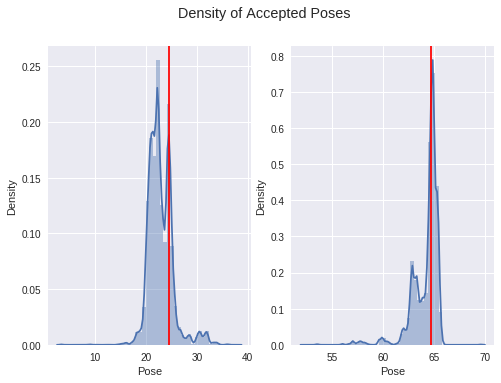

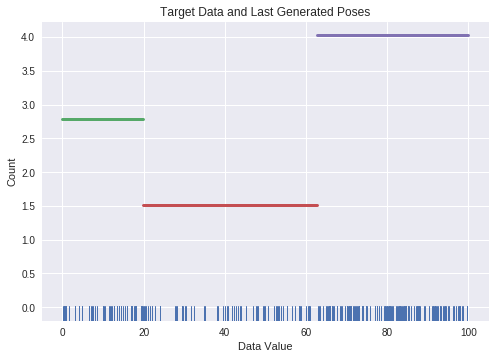

In [0]:
# This cell illustrates how the pose_move works for our test case. 
heights = exh
# heights = [1., 3., 2.] #see how changing the heights impacts things
changepts = [0, 30, 80, 100]
k = 4
alpha = exa
beta = exb
example_data = data
obs_func = lambda x, y: sum(1 for i in example_data if x <= i <= y)

new_poses = []
for i in range(0,40000):
  changepts = pose_move(changepts, heights, k, obs_func)
  if i >= 4000: #allow time for burn-in
    new_poses.append(tuple(changepts))

fig, ax = plt.subplots(1, 2)
for i in range(0, 2):
  sns.distplot([m[i+1] for m in new_poses], kde=True, rug=False, ax=ax[i])
  ax[i].axvline(x=exc[i+1], color='r')
  ax[i].set_xlabel('Pose')
  ax[i].set_ylabel('Density')
fig.suptitle('Density of Accepted Poses')


plt.figure()
sns.distplot(example_data, kde=False, rug=True, hist=False)
for i in range(0,len(heights)):
  plt.plot([changepts[i], changepts[i+1]],[heights[i],heights[i]], lw=3)
plt.title('Target Data and Last Generated Poses')
plt.xlabel('Data Value')
plt.ylabel('Count')

Not so bad (if we already know the rates). Change up the heights to see how the poses change. 

So far we've assumed that we know the number of change points that exist. But more than likely , we don't (or we have a suspicion (like we've introduced an intervention) and we want to independently see if we can find an impact). This introduces the two bread-and-butter moves for RJMCMC: *birth* and *death.*

These moves **will** change the dimensionality of the models we are considering. In Greene's paper, the *birth_move* is outlined in detail, and we repeat it here for clarity.

A new change point, $s^*$ will, with probability 1, lie within an existing interval; inserting the new point will cause relabelling of existing change points such that $s_{j+1} = s^*, s_{j+2} = s_{j+1}^*, ...$ and so on (with similar updates to the height indexing). We will also want to propose new heights over the intervals $(s_{j}, s^*)$ and $(s^*, s^{j+1})$. Intuitively, we don't want to throw away the height $h_j$ over the existing interval, so we propose to perturb the height. For simplicity in claculation, but also intuitively, we choose to define the perturbation as a geometric mean, such that:

$$(s^* - s_j)log(h_{j}^*) + (s_{j+1} - s^*)log(h_{j+1}^*) = (s_{j+1} - s_j)log(h_j)$$

and

$$\frac{h_{ j+1}^*}{h_{j}^*} = \frac{1-u}{u}$$

where $u$ is an auxilary variable drawn from a uniform distribution from 0 to 1.

The form of the acceptance probability can be most helpfully expressed as:

$$min(1, L \times Prior Ratio \times Proposal Ratio \times Jacobian)$$

where we make special note that the Jacobian is necessary for the dimension conversion that occurs when adding a change point. Specifically, we can write each term following from the discussion of preserving detailed balance as:

$$log(L) = \sum_{i = 1}^n log(x_p(y_i)) - \int_0^L x_p(t) dt - \sum_{i = 1}^n log(x(y_i)) + \int_0^L x(t) dt$$

where:

$$-\int_0^L x_p(t) dt + \int_0^L x(t) dt = -h_{j}^*(s^* - s_{j}) - h_{j+1}^*(s_{j+1} -  s^*) + h_{j}(s_{j+1} - s_{j})$$

and:

$$\sum_{i = 1}^n log(x_p(y_i)) - \sum_{i = 1}^n log(x(y_i)) = \mu_{j}^*log(h_{j}^*) + \mu_{j+1}^*log(h_{j+1}^*) - \mu_{j}log(h_j)$$

where $\mu_{j}^*$ is the number of observations in $(s_j, s^*)$, $\mu_{j+1}^*$ is the number of observations in $(s_{j}^*, s_{j+1}^*)$, and $\mu_{j}$ is the number of observations in the original interval $(s_j, s_{j+1})$.

The prior ratio follows from the text, and includes an update related to $k$:

$$Pr_k = \frac{p(k+1)}{p(k)} \frac{2(k+1)(2k+3)}{l^2} $$

where $l$ is the upper bound on the valid range; an update of the position (which follows from the uniform distribution):

$$Pr_s = \frac{(s^*-s_j)(s_{j+1} - s^*)}{s_{j+1} - s_j}$$

and an update to height, following from the gamma distribution:

$$Pr_h = \frac{\beta^\alpha}{\Gamma (\alpha)}\frac{h_{j}^*h_{j+1}^*}{h_j}^{\alpha-1} exp(-\beta (h_{j}^* + h_{j+1}^* - h_{j}))$$

The proposal ratio is the quantity which balances the birth and death moves (therefore satisfying "reversibility"):

$$\frac{d_{k+1}l}{b_k(k+1)}$$

And the Jacobian (which satisfies detailed balance and allows for us to change dimensions):

$$J = \frac{(h_j^* + h_{j+1}^*)^2}{h_j}$$.

Now, we can write this function out:




In [0]:
def birth_move(changepts, heights, k, L, alpha, beta, lamb, birth, death, obs_func):
    '''Move that creates a changepoint (increases dimensionality, k+1)
    INPUT:
     - changepts (list of floats)
     - heights (list of floats)
     - k (int)
     - L (list of floats): the bounds on s
     - alpha (int)
     - beta (float)
     - lamb (float)
     - birth (function handle): provides the right probability of bk
     - death (function handle): provides the right probability of dk
     - obs_func (function handle): provides ability to count obs in interval
    RETURNS: heights, changepts, k'''
    #choose a random position within the valid interval
    #determine in which interval this currently lies
    j = -1
    while j == -1:
      sp = np.random.uniform(L[0], L[1])
      for i in range(0, len(heights)):
        if sp < changepts[i+1] and sp > changepts[i]:
          j = i   
    
    #hand-coded check to remain within the known bounds
    if j == 1 and len(changepts) == 2:
      j = 0
    
    #propose the corresponding height changes (hp1, hp2)
    u = np.random.uniform(0, 1)
    m = (changepts[j+1] - sp)/(changepts[j+1]-changepts[j]) * np.log((1-u)/u)
    hp1 = np.exp(np.log(heights[j]) - m)
    hp2 = (1-u)/u * hp1
        
    #count observations
    obs1, obs2 = obs_func(changepts[j], sp), obs_func(sp, changepts[j+1])
    total = obs1 + obs2
    
    #calculate acceptance probability
    log_likelihood = -hp1*(sp-changepts[j]) - hp2*(changepts[j+1]-sp) + heights[j]*(changepts[j+1]-changepts[j]) + \
                     obs1*np.log(hp1) + obs2*np.log(hp2) - total*np.log(heights[j])
        
    kp = p(k+1, lamb)/p(k, lamb) * (2*(k+1)*(2*k+3))/np.power((L[1]-L[0]),2)
    spr = ((sp-changepts[j])*(changepts[j+1]-sp))/(changepts[j+1] - changepts[j])
    
    m = np.power(beta, alpha) / gamma(alpha)
    n = np.power(((hp1*hp2)/heights[j]), alpha-1)
    l = hp1+hp2-heights[j]
    hp = m * n * np.exp(-beta*(l))
    prior = kp*spr*hp
    
    proposal = (death(k)*(L[1]-L[0]))/(birth(k)*(k+1))
    
    jacobian = np.power(hp1 + hp2, 2) / heights[j]
    
    
    prob = min(1, np.exp(log_likelihood) * prior * proposal * jacobian)

    #return updated heights and changepts
    if np.random.uniform() < prob:
      changepts = list(tuple(changepts[:j+1]))+list(tuple([sp]))+list(tuple(changepts[j+1:]))
      new_heights = []
      if j > 0:
        new_heights = new_heights + list(tuple(heights[:j]))
      new_heights = new_heights + list(tuple([hp1, hp2]))
      if j < k:
        new_heights = new_heights + list(tuple(heights[j+1:]))
      heights = list(new_heights)
      k = k + 1
    
    return heights, changepts, k

The *death_move* follows directly from the birth move, with the ratio terms inverted:


In [0]:
def death_move(changepts, heights, k, L, alpha, beta, lamb, birth, death, obs_func):
    '''Move that deletes a changepoint (reduces dimensionality, k-1)
    INPUT:
     - changepts (list of floats)
     - heights (list of floats)
     - k (int)
     - L (list of floats): the bounds on s
     - alpha (int)
     - beta (float)
     - lamb (float)
     - birth (function handle): provides the right probability of bk
     - death (function handle): provides the right probability of dk
     - obs_func (function handle): provides ability to count obs in interval
    RETURNS: heights, changepts, k'''
    
    #randomly choose a changept to delete
    j = np.random.randint(0, max(k-2, 2)) #note! we're actually removing j+1

    #propose the new height
    m = (changepts[j+1] - changepts[j])*np.log(heights[j])
    n = (changepts[j+2] - changepts[j+1])*np.log(heights[j+1])
    hp = np.exp((m+n)/(changepts[j+2]-changepts[j]))
    
    #get the observations
    obs1, obs2 = obs_func(changepts[j], changepts[j+1]), obs_func(changepts[j+1], changepts[j+2])
    total = obs1 + obs2
    
    #calculate the acceptance rate
    log_likelihood = -hp * (changepts[j+2] - changepts[j]) + heights[j] * (changepts[j+1] - changepts[j]) + \
                      heights[j+1] * (changepts[j+2] - changepts[j+1]) + total * np.log(hp) - \
                      obs1 * np.log(heights[j]) - obs2 * np.log(heights[j+1])
    
    prior = p(k-1, lamb)/p(k, lamb) * (np.power((L[1]-L[0]),2) / (2*(k-1)*(2*k-3))) * \
            (changepts[j+2]-changepts[j])/((changepts[j+1] - changepts[j])*(changepts[j+2]-changepts[j+1])) * \
            gamma(alpha)/np.power(beta,alpha) * np.power((heights[j]*heights[j+1]/hp),(alpha-1)) * 1/np.exp(-beta*(heights[j]+heights[j+1]-hp))
    
    proposal = (birth(k-2)*(k-1))/(death(k-1)*(L[1]-L[0]))
    
    jacobian = hp/np.power(heights[j] + heights[j+1], 2)
    
    prob = min(1, np.exp(log_likelihood) * prior * proposal * jacobian)
    
    #return updated heights and changepts
    if np.random.uniform() < prob:
      changepts = list(tuple(changepts[:j+1])) + list(tuple(changepts[j+2:]))
      heights = list(tuple(heights[:j])) + list(tuple([hp])) + list(tuple(heights[j+2:]))
      k = k - 1
    return heights, changepts, k

There is one last element to introduce, which is the prior on k (we care about the parameters in our inference). The authors assume a Poisson prior of the form:

$$p(k) = e^{-\lambda}\frac{\lambda^k}{k!}$$

and assume that there is an upperbound on the number of steps that can be present $k_{max}$. We encode this function as:

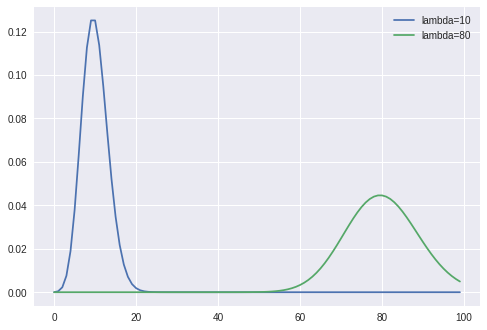

In [0]:
def p(k, lamb):
    '''Method for calculating the prior on k'''
    if k > 0:
      return np.exp(-lamb) * lamb**k / np.math.factorial(k)
    else:
      return 0

plt.plot([p(k, 10) for k in range(0,100)], label='lambda=10')
plt.plot([p(k, 80) for k in range(0,100)], label='lambda=80')
plt.legend()

Now let's see what happens with our toy example (remember, the heights and poses may be a little off, since we can't change those directly in this form).

[0, 63.82280114116084, 100]
[3.5386623830757276, 4.965360048269013]


Text(0, 0.5, 'Normed Count')

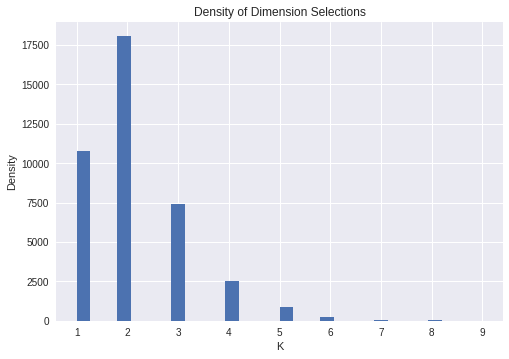

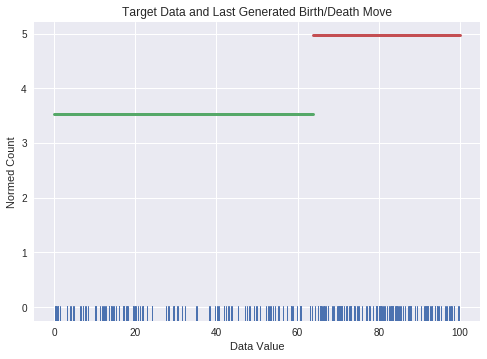

In [0]:
heights = [4]
changepts = [0, 100]
L = [0, 100]
k = 2
kmax = 30
alpha = exa
beta = exb
lamb = 4 #since we know the dimensionality of the system we can bias this to select 2 change points
birth = lambda t: (0.9/2) * min(1, p(t+1,lamb)/p(t,lamb))
death = lambda t: (0.9/2) * min(1, p(t,lamb)/p(t+1,lamb))
example_data = data
obs_func = lambda x, y: sum(1 for i in example_data if x <= i <= y)

new_poses = []
new_heights = []
new_dimensions = []
for i in range(0,44000):
  if (np.random.uniform() > 0.5 or k >= kmax) and len(heights) > 2:
    heights, changepts, k = death_move(changepts, heights, k, L, alpha, beta, lamb, birth, death, obs_func)
  else:
    heights, changepts, k = birth_move(changepts, heights, k, L, alpha, beta, lamb, birth, death, obs_func)
  if i >= 4000: #allow for burn-in
    new_poses.append(tuple(changepts))
    new_heights.append(tuple(heights))
    new_dimensions.append(int(k)-2) #subtracting two to remove endpoints
  
plt.figure()
plt.hist(new_dimensions,bins=kmax)
plt.title('Density of Dimension Selections')
plt.xlabel('K')
plt.ylabel('Density')

plt.figure()
sns.distplot(example_data, kde=False, hist=False, rug=True)
print(changepts)
print(heights)
for i in range(0,len(heights)):
  plt.plot([changepts[i], changepts[i+1]],[heights[i],heights[i]], lw=3)
plt.title('Target Data and Last Generated Birth/Death Move')
plt.xlabel('Data Value')
plt.ylabel('Normed Count')
 

#The Sampler

Great! So we've walked through each of the moves that are required for this sampling problem. There are two moves which adjust parameters within a dimension (moving height and changepoint positions), and two moves which actually form the basis of the "reversible jump" aspect of RJMCMC: birth and death of changepoints, which leads to changing parameter dimensions. These two moves *must* coexist in this framework in order to make claims about RJMCMC satisfying detailed balance, reversibility/invertibility, and ergodicity.

With these moves, all that is left is establishing a sampling framework:

In [0]:
def rjmcmc(data, changepts, heights, kmax, lamb, alpha, beta, iters):
  '''Function which implements the RJMCMC for the coal mining disaster
     specified in Greene
     Inputs:
     data (list of floats): observations
     changepts (list of floats): initialize the location of changepoints
     heights (list of floats): initialize the height of the steps
     kmax (int): maximum number of changepoints allowed to consider
     lamb (int): hyperparam
     alpha (int): hyperparam
     beta (int): hyperparam
     iters (int): number of samples to collect
  '''
  
  # get the initialized number of change points, k
  k = len(changepts)
  track_k = [int(k)-2]
  track_h = [list(tuple(heights))]
  track_s = [list(tuple(changepts))]
  
  # set the bounds
  L = [min(data), max(data)]
  
  # lambda function for counting the number of data points in each step
  num_observations = lambda l, r: sum(1 for i in data if l <= i <= r)
   
  # draw samples for as many interations specified  
  for i in range(iters):
    # get the move probabilities, estalished in Greene
    birth = lambda t: (3.6/7) * min(1, p(t+1,lamb)/p(t,lamb))
    death = lambda t: (3.6/7) * min(1, p(t,lamb)/p(t+1,lamb))
    pk = 0 if k <= 1 else 0.5*(1-birth(k)-death(k-1)) #position
    hk = 1.-birth(k)-death(k-1)-pk #height
    
    # select a move and apply
    move_type = np.random.uniform()
    
    if move_type > 1-hk:
      heights = height_move(changepts, heights, k, alpha, beta, num_observations)
    elif move_type > (1-(hk + pk)):
      changepts = pose_move(changepts, heights, k, num_observations)  
    elif move_type > birth(k) and len(heights) > 2: #only kill a node if there are enough
      heights, changepts, k = death_move(changepts, heights, k, L, alpha, beta, lamb, birth, death, num_observations)
    else:
      if k < kmax: #only birth a node if we're not already maxed out
        heights, changepts, k = birth_move(changepts, heights, k, L, alpha, beta, lamb, birth, death, num_observations)
      else:
        pass
    
    track_k.append(int(k)-2)
    track_h.append(list(tuple(heights)))
    track_s.append(list(tuple(changepts)))
    
  return track_h, track_s, track_k

And, let's see this play out on our toy data set:

Text(0, 0.5, 'Count')

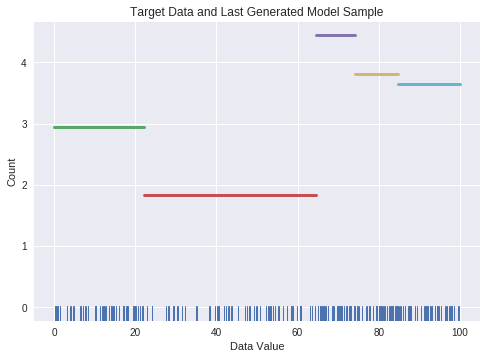

In [0]:
example_data = data
changepts = [0,100]
heights = [4]
kmax = 30
lamb = 4
alpha = exa
beta = exb
iters = 44000

# run the sampler
h, s, ks = rjmcmc(example_data, changepts, heights, kmax, 
                  lamb, alpha, beta, iters)

#inspect the last element
plt.figure()
sns.distplot(example_data, kde=False, hist=False, rug=True)
for i in range(0,len(h[-1])):
  plt.plot([s[-1][i], s[-1][i+1]],[h[-1][i],h[-1][i]], lw=3)
plt.title('Target Data and Last Generated Model Sample')
plt.xlabel('Data Value')
plt.ylabel('Count')

Text(0.5, 1.0, 'Distribution over Rates')

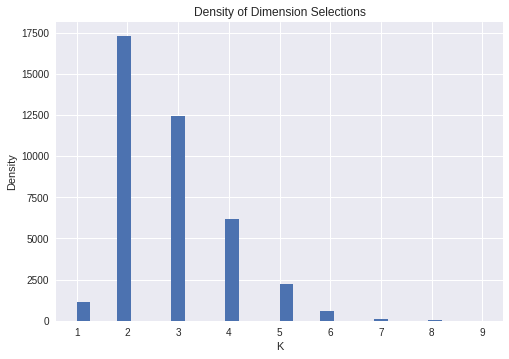

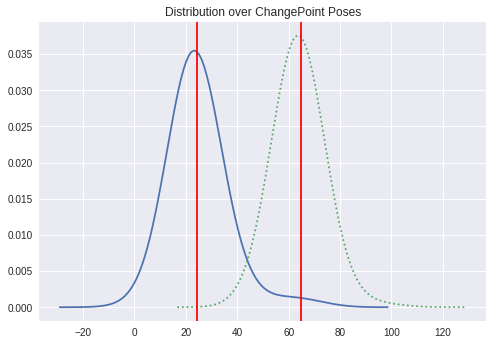

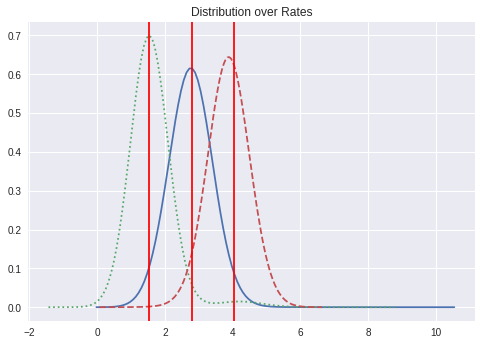

In [0]:
# inspect the number of dimensions
# Note: burn-in around 4000 samples
plt.figure()
plt.hist(ks[4000:],bins=kmax)
plt.title('Density of Dimension Selections')
plt.xlabel('K')
plt.ylabel('Density')

# inspect the poses and rates, conditioned on 2
a = pd.Series(ks[4000:])
ind = a[a==2].index

s2 = np.array(s[4000:])[ind]
ptsa = [m[1] for m in s2]
ptsb = [m[2] for m in s2]

h2 = np.array(h[4000:])[ind]
htsa = [m[0] for m in h2]
htsb = [m[1] for m in h2]
htsc = [m[2] for m in h2]

plt.figure()
sns.kdeplot(np.array(ptsa), kernel='gau', bw=10)
sns.kdeplot(np.array(ptsb), kernel='gau', bw=10, linestyle=":")
plt.axvline(x=exc[1], color='r')
plt.axvline(x=exc[2], color='r')
plt.title('Distribution over ChangePoint Poses')

plt.figure()
sns.kdeplot(np.array(htsa), kernel='gau', bw=0.5)
sns.kdeplot(np.array(htsb), kernel='gau', bw=0.5, linestyle=":")
sns.kdeplot(np.array(htsc), kernel='gau', bw=0.5, linestyle="--")
plt.axvline(x=exh[0], color='r')
plt.axvline(x=exh[1], color='r')
plt.axvline(x=exh[2], color='r')
plt.title('Distribution over Rates')

What can we conclude from this? In these more or less "perfect" circumstances, it seems that RJMCMC does a pretty good job on our toy dataset. But...what about on real data? 

# Coal Mining Disasters

Let's take a look on how our sampler performs on the coal mining disaster data, and compare against the figures in the paper.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Rates')

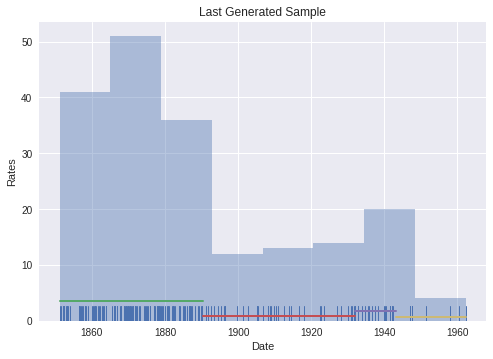

In [0]:
h, c, ks = rjmcmc(coal_df.date.values, [min(coal_df.date.values), max(coal_df.date.values)], 
                  [2.1], 30, lamb=3, alpha=1, beta=200/365.25, iters=44000) 

sns.distplot(coal_df.date.values, kde=False, rug=True, norm_hist=False)
for i in range(0,len(h[-1])):
  plt.plot([c[-1][i],c[-1][i+1]], [h[-1][i],h[-1][i]], lw=2)

plt.title('Last Generated Sample')
plt.xlabel('Date')
plt.ylabel('Rates')

First, let's inspect Figure 2 in the paper, the distribution over the number of change points. Here is what Greene found:

![](https://drive.google.com/uc?export=view&id=1nFc-JX0wVl1UMGxFmVwCqbmfwq3ielsR)




Text(0, 0.5, 'Density')

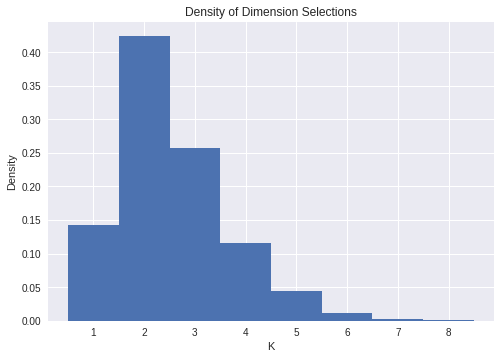

In [0]:
# inspect the number of dimensions
# Note: burn-in around 4000 samples
plt.figure()
plt.hist(ks[4000:],bins=np.linspace(0.5, 8.5, 9), density=1)
plt.title('Density of Dimension Selections')
plt.xlabel('K')
plt.ylabel('Density')

It seems that the general trend of our sampler and their's agree: the mode is somewhere from 1-3 change points, with diminishing visits to higher dimensions. How about the location of the change points? Greene at al found:

![](https://drive.google.com/uc?export=view&id=1-RsCGLqiyUWQ3w_5WYrIDZcnRxgW9IBz)


(1851.20260095825, 1962.2197125256698)

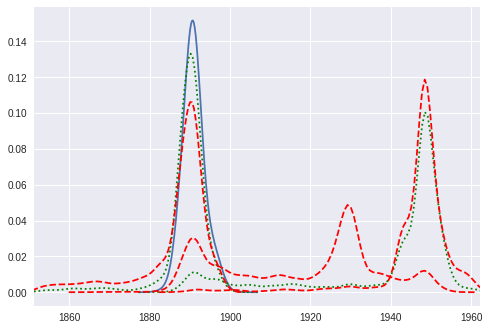

In [0]:
# inspect the poses and rates, conditioned on 2
a = pd.Series(ks[4000:])
ind1 = a[a==1].index
ind2 = a[a==2].index
ind3 = a[a==3].index

s1 = np.array(c[4000:])[ind1]
s2 = np.array(c[4000:])[ind2]
s3 = np.array(c[4000:])[ind3]

ptsa1 = [m[1] for m in s1]

ptsa2 = [m[1] for m in s2]
ptsb2 = [m[2] for m in s2]

ptsa3 = [m[1] for m in s3]
ptsb3 = [m[2] for m in s3]
ptsc3 = [m[3] for m in s3]


sns.kdeplot(np.array(ptsa1), kernel='gau', bw=625/365.24)
sns.kdeplot(np.array(ptsa2), kernel='gau', bw=625/365.24, linestyle=":", color='g')
sns.kdeplot(np.array(ptsb2), kernel='gau', bw=625/365.24, linestyle=":", color='g')
sns.kdeplot(np.array(ptsa3), kernel='gau', bw=625/365.24, linestyle="--", color='r')
sns.kdeplot(np.array(ptsb3), kernel='gau', bw=625/365.24, linestyle="--", color='r')
sns.kdeplot(np.array(ptsc3), kernel='gau', bw=625/365.24, linestyle="--", color='r')

sns.plt.xlim([min(coal_df.date.values), max(coal_df.date.values)])


We've got very similar trends for the major peaks, with a few notable changes, particularly no partition noted in and around 1930 like that shown by Greene . 

Finally, let's look at the rates. Greene found the following:

![alt text](https://drive.google.com/uc?export=view&id=1HT2U8MQcpi05Fnb8_EAROqbfwdP45jxt)


(0.0, 0.015)

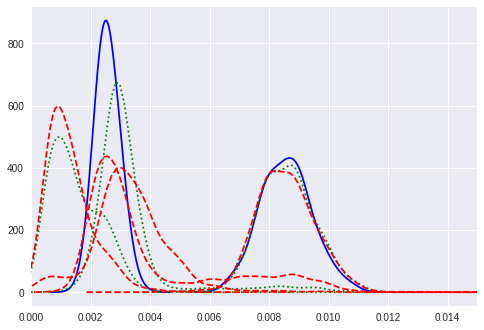

In [0]:
#heights
h1 = np.array(h[4000:])[ind1]
h2 = np.array(h[4000:])[ind2]
h3 = np.array(h[4000:])[ind3]

ha1 = [m[0]/365.25 for m in h1]
hb1 = [m[1]/365.25 for m in h1]

ha2 = [m[0]/365.25 for m in h2]
hb2 = [m[1]/365.25 for m in h2]
hc2 = [m[2]/365.25 for m in h2]

ha3 = [m[0]/365.25 for m in h3]
hb3 = [m[1]/365.25 for m in h3]
hc3 = [m[2]/365.25 for m in h3]
hd3 = [m[3]/365.25 for m in h3]

sns.kdeplot(np.array(ha1), kernel='gau', bw=0.0003, color='b')
sns.kdeplot(np.array(hb1), kernel='gau', bw=0.0003, color='b')
sns.kdeplot(np.array(ha2), kernel='gau', bw=0.0003, linestyle=':', color='g')
sns.kdeplot(np.array(hb2), kernel='gau', bw=0.0003, linestyle=':', color='g')
sns.kdeplot(np.array(hc2), kernel='gau', bw=0.0003, linestyle=':', color='g')
sns.kdeplot(np.array(ha3), kernel='gau', bw=0.0003, linestyle='--', color='r')
sns.kdeplot(np.array(hb3), kernel='gau', bw=0.0003, linestyle='--', color='r')
sns.kdeplot(np.array(hc3), kernel='gau', bw=0.0003, linestyle='--', color='r')
sns.kdeplot(np.array(hd3), kernel='gau', bw=0.0003, linestyle='--', color='r')

sns.plt.xlim(0.0, 0.015)



This is also comparable to the results found by greene, with similar peak locations.

#Conclusions

This tutorial walked through the change-point example presented in RJMCMC with a toy dataset and a real dataset. Some descrepencies that are notable from the results in Greene may be accounted for the following liberties taken by these authors:


*   Setting the birth/death constant c and establishing move selection ratios
*   Logic on valid moves and random index selection
*   Use of "baked in" uniform sampling functions

And a notable difference in compute power: Greene found his results in 1995, and there may be some discrepency in precision available between his machine and this hosted machine.

Regardless of the discrepencies, we find that RJMCMC as a framework is intuitive in form, but can be tricky to implement practically. The concept, however, of having dimension-flexibility is powerful, and conceptually ties in to Bayesian non-parametrics which will be covered next in the class.

### Acknowledgements
We would like to acknowledge inspiration from the code provided by 2018's RJMCMC lecture group.

